<h3><b> Chapter 10: Deep Learning </b></h>

In [2]:
# Libraries
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import train_test_split, GridSearchCV

# Torch-specific imports
import torch
import json
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import MeanAbsoluteError, R2Score
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
from ISLP.torch import SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential
from glob import glob
from torchinfo import summary
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor

In [3]:
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)

Seed set to 0


<b> Q7 </b>

In [9]:
# Load data
default = load_data('Default').dropna()
n = default.shape[0]

# Data preprocessing
model = MS(default.columns.drop("default"), intercept=False)
X = model.fit_transform(default).to_numpy()
Y = np.where(default["default"] == "Yes", 1, 0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/5, random_state=1)

# Specifying neural network
class DefaultModel(nn.Module):

    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))
default_model = DefaultModel(X.shape[1])
summary(default_model, input_size=X_train.shape, col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [8000, 3]                 [8000]                    --
├─Flatten: 1-1                           [8000, 3]                 [8000, 3]                 --
├─Sequential: 1-2                        [8000, 3]                 [8000, 1]                 --
│    └─Linear: 2-1                       [8000, 3]                 [8000, 10]                40
│    └─ReLU: 2-2                         [8000, 10]                [8000, 10]                --
│    └─Dropout: 2-3                      [8000, 10]                [8000, 10]                --
│    └─Linear: 2-4                       [8000, 10]                [8000, 1]                 11
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.10
Forward/backward pass size (MB): 0.70
Params size (MB): 0.00
Estimated Total Size (MB): 0.80

In [10]:
# Data preprocessing
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
default_train = TensorDataset(X_train_t, Y_train_t)
default_test = TensorDataset(X_test_t, Y_test_t)

In [11]:
# Max workers = 12 for this PC
max_num_workers = rec_num_workers()
default_dm = SimpleDataModule(default_train, 
                              default_test,
                              batch_size=32,
                              num_workers=min(4, max_num_workers),
                              validation=default_test)
default_module = SimpleModule.regression(default_model, metrics={"MAE":MeanAbsoluteError()})
default_logger = CSVLogger("logs", name="default")

# Trainer
default_trainer = Trainer(deterministic=True,
                          max_epochs=50,
                          log_every_n_steps=5,
                          logger=default_logger,
                          callbacks=[ErrorTracker()])
default_trainer.fit(default_module, datamodule=default_dm)
default_trainer.test(default_module, datamodule=default_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | DefaultModel | 51     | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 49: 100%|██████████| 250/250 [00:01<00:00, 187.24it/s, v_num=3]       

`Trainer.fit` stopped: `max_epochs=50` reached.


Testing DataLoader 0: 100%|██████████| 63/63 [00:00<00:00, 336.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_MAE            0.0662161111831665
        test_loss          0.028720347210764885
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.028720347210764885, 'test_MAE': 0.0662161111831665}]

tensor(0.0662, grad_fn=<MeanBackward0>)


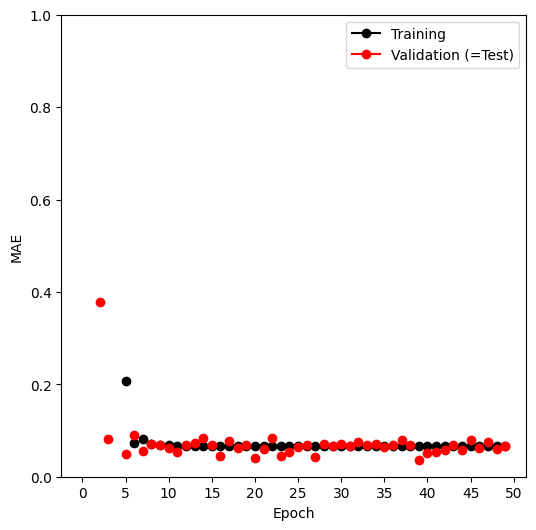

In [12]:
# Summary of results
default_results = pd.read_csv(default_logger.experiment.metrics_file_path)
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column, color, label) in zip([f'train_{col}_epoch',
                                       f'valid_{col}'],
                                      ['black', 'red'],
                                      [training_legend, valid_legend]):
        results.plot(x='epoch', y=column, label=label, marker='o', color=color, ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(default_results,
                  ax,
                  col='MAE',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 1])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

default_model.eval() 
preds = default_module(X_test_t)
print(torch.abs(Y_test_t - preds).mean())

In [13]:
# Comparison with linear logit
logit = LogisticRegression().fit(X_train, Y_train)
ypred = logit.predict(X_test)
mae = np.abs(Y_test - ypred).mean()
print(mae)

0.026


Using MAE, linear logistic regression outperforms deep learning. This may be due to the training set size to be not as large for deep learning to have its use (n=8000 for k=51).

In [14]:
# Cleanup
del(default,
    default_model, default_dm,
    default_logger,
    default_test, default_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    default_trainer, default_module)

<b> Q9 </b>

In [102]:
# Load data
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(with_mean=True, with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

# Create lagged data
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

# Split X and Y
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)

# Fit AR5 Model
M = LinearRegression()
M.fit(X[train], Y[train])
print(f"R-squared value = {round(M.score(X[~train], Y[~train]), 4)}")

R-squared value = 0.4129


In [105]:
# Load data
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(with_mean=True, with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

# Create lagged data
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])

# Add 12-level variable "month"
X.index = pd.to_datetime(X.index)
X["month"] = X.index.month
X = X.dropna()

# Split X and Y
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)

# Fit AR5 Model
M = LinearRegression()
M.fit(X[train], Y[train])
print(f"R-squared value = {round(M.score(X[~train], Y[~train]), 4)}")

R-squared value = 0.4117


The factor does not improve the model.

<b> Q10 </b>

<b> Q12 </b>

In [53]:
# Data with variable day_of_week as dummy
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(with_mean=True, with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

# Create lagged data
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X_day = pd.concat([X, pd.get_dummies(NYSE['day_of_week'])], axis=1).dropna()

# Refit the data with lag 5 (NEED CHANGE)
# ordered_cols = []
# for lag in range(5,0,-1):
#     for col in cols:
#         ordered_cols.append('{0}_{1}'.format(col, lag))
# X_day = X_day.reindex(columns=ordered_cols)
# X_rnn = X_day.to_numpy().reshape((-1,5,3))

In [43]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

In [44]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

summary(nyse_model, input_data=X_rnn_t, col_names=['input_size', 'output_size', 'num_params'])

C:\Users\winso\AppData\Local\Temp\ipykernel_10572\2602126799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))
C:\Users\winso\AppData\Local\Temp\ipykernel_10572\2602126799.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_t = torch.tensor(Y[mask].astype(np.float32))


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [45]:
nyse_dm = SimpleDataModule(nyse_train, nyse_test, num_workers=min(4, max_num_workers),
                           validation=nyse_test, batch_size=64)
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break
    
nyse_optimizer = RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(nyse_model, optimizer=nyse_optimizer, metrics={'r2':R2Score()})
nyse_trainer = Trainer(deterministic=True, max_epochs=200, enable_progress_bar=False, callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module, datamodule=nyse_dm)
nyse_trainer.test(nyse_module, datamodule=nyse_dm)


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NYSEModel | 217    | train
1 | loss  | MSELoss   | 0      | train
--------------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
`Trainer.fit` stopped: `max_epochs=200` reached.


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6203494668006897
         test_r2            0.41125810146331787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6203494668006897, 'test_r2': 0.41125810146331787}]

R-squared is shown to be around 41.284% for the lag-5 autoregressive model.

,DJ_return_1,log_volume_1,log_volatility_1,DJ_return_2,log_volume_2,log_volatility_2,DJ_return_3,log_volume_3,log_volatility_3,DJ_return_4,log_volume_4,log_volatility_4,DJ_return_5,log_volume_5,log_volatility_5,mon,tues,wed,thur,fri
date,,,,,,,,,,,,,,,,,,,,
1962-12-10,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,0.434813,2.283789,-2.418037,0.905200,1.517291,-2.529058,-0.549823,0.175075,-4.357078,True,False,False,False,False
1962-12-11,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,0.434813,2.283789,-2.418037,0.905200,1.517291,-2.529058,False,True,False,False,False
1962-12-12,-0.006294,-0.013661,-1.505667,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,0.434813,2.283789,-2.418037,False,False,True,False,False
1962-12-13,0.377081,0.042552,-1.551515,-0.006294,-0.013661,-1.505667,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,-0.431397,0.935176,-2.366521,False,False,False,True,False
1962-12-14,-0.411718,-0.419836,-1.597607,0.377081,0.042552,-1.551515,-0.006294,-0.013661,-1.505667,-1.304126,0.605918,-1.366028,0.046340,0.224779,-2.500970,False,False,False,False,True
